# Joe Stanley
### Stanley Solutions
Testing and modeling environment for water heating/cooling model.

References:
- http://jwilson.coe.uga.edu/EMAT6680Fa07/Lowe/Assignment%2012/CoolingWater.html
- https://sciencing.com/calculate-time-heat-water-8028611.html

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import convert_temperature as conv_temp

# Define System Parameters
k = 0.01457 # From Web, not Terribly Accurate
g = 10 # Gallons in Container
P = 500

###### ALL TIME IS MEASURED IN MINUTES #####

In [2]:
# Define Modeling Functions
def gallons(liters):
    gal = liters/3.78541
    return(gal)
def liters(gallons):
    lit = gallons*3.78541
    return(lit)

def newtoncooling(t,temp0,tempenv):
    temp = tempenv + (temp0-tempenv)*np.exp(-k*t)
    return(temp)

def heating(t,Power,temp0):
    temp0 = conv_temp(temp0,'f','c')
    Pkw = Power/1000
    temp = temp0 + (60*Pkw*t)/(4.2*liters(g))
    print(temp0,Pkw,liters(g))
    temp = conv_temp(temp,'c','f')
    return(temp)

def combined(t,Power,temp0,tempenv):
    cool = newtoncooling(t,temp0,tempenv)
    heat = heating(t,Power,temp0) - temp0
    return(cool+heat)

1.6666666666666856 0.5 37.8541
1.6666666666666856 0.5 37.8541


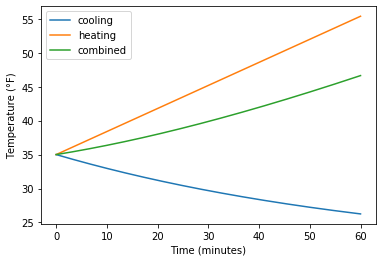

In [3]:
# Model SIMPLE Systems, Nothing Advanced
t_hr = np.linspace(0,60,600)
t0 = 35
te = 20
cool = newtoncooling(t_hr,t0,te)
heat = heating(t_hr,P,t0)
sys = combined(t_hr,P,t0,te)
plt.plot(t_hr, cool, label='cooling')
plt.plot(t_hr, heat, label='heating')
plt.plot(t_hr, sys, label='combined')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.show()

## First model was not accurate...
It did not appropriately account for time.

In [4]:
# Define Avista Billing Rates
ratelt600 = 0.08458 # $/kwh
rategt600 = 0.09521 # $/kwh

In [27]:
# Define New Temperature Model
class troughmodel():
    def __init__(self,temp0,Pwatts,volume,k,threshold=45,freezing_threshold=33):
        # Define Simple Heater
        self._t0 = temp0
        self._Pkw = Pwatts/1000
        self._k = k
        self._temp = [temp0]
        self._heater_en = [False]
        self._threshold = threshold
        self._volume = volume
        self._index = 0
        self._tactv = freezing_threshold # Frezing, Activate Point
    
    def update(self,ambient,EN=True,k=None):
        # Temperature over Time Method, Models Heater and Cooling Params
        if k != None:
            self._k = k
        temp = self._temp[self._index]
        # Determine Temperature Change from Both Heating and Cooling
        newTemp = ambient + (temp-ambient)*np.exp(-self._k)
        heatC = (temp-32)*5/9 + (60*self._Pkw)/(4.2*liters(self._volume))
        heat = (heatC*9/5) + 32
        # Convert Heating Effect back to Fahrenheit
        dt_heat = heat-temp
        # Determine whether Heater should be Applied
        if temp >= self._threshold:
            self._heater_en.append(False) # Don't Heat
        elif EN and ((temp <= self._tactv) or self._heater_en[self._index-1]):
            self._heater_en.append(True) # Apply Heater
            newTemp += dt_heat
        else:
            self._heater_en.append(False) # Don't Heat
        # Increment Index and Return New Temperature
        self._index += 1
        self._temp.append(newTemp)
        return(newTemp)
    
    def min_maintain(self,temp_maint=None):
        # Minimum Maintainable Temperature Method; Determines Minimum Ambient
        # Temperature to Maintain (at least) the Maintenence Temperature
        temp = self._tactv # Freezing Point
        if temp_maint != None:
            temp = temp_maint
        # Iteratively Process Temperatures between -10 and 32
        for ambient in range(-10,32):
            # Determine Temperature Change from Both Heating and Cooling
            dcool = temp - (ambient + (temp-ambient)*np.exp(-self._k))
            heatC = (temp-32)*5/9 + (60*self._Pkw)/(4.2*liters(self._volume))
            heat = (heatC*9/5) + 32
            dheat = heat-temp
            if dheat >= dcool:
                mintemp = ambient
                return(mintemp)
    
    def time_to_recover(self,ambient,temp_recovr=None,t0=None):
        # Time to Recover Method; Determines the Time (in minutes) required
        # to Heat the Modeled Trough from Ambient to the Recovery Threshold
        time = 0
        if t0 == None:
            temp = ambient
        else:
            temp = t0
        if temp_recovr == None:
            temp_recovr = self._tactv
        # Iteratively Process the Heating/Cooling Performance to Determine
        # the Time Required; Return -1 if more than 24 Hours Required
        while temp < temp_recovr:
            heatC = (temp-32)*5/9 + (60*self._Pkw)/(4.2*liters(self._volume))
            heat = (heatC*9/5) + 32
            dt_heat = heat-temp
            temp = ambient + (temp-ambient)*np.exp(-self._k) + dt_heat
            time += 1
            if time > 1440:
                return(-1) # Return in Error
        return(time)
    
    def rest_time(self,ambient,temp_restart=32,t0=None):
        # Determine the Allowable Resting Time Before a Heater Restart is Required
        time = 0
        if t0 == None:
            temp = self._temp[self._index]
        else:
            temp = t0
        heaterstate = self._heater_en[-1]
        if not heaterstate:
            # Iteratively Calculate New Temperature and Count Time (in minutes)
            # If Time is Greater than 24 Hours, Return -1
            while temp > temp_restart:
                # Determine Temperature Change from Both Heating and Cooling
                newTemp = ambient + (temp-ambient)*np.exp(-self._k)
                temp = newTemp
                time += 1
                if time > 1440:
                    return(-1) # Indicate Greater than 24 Hours Cool
        else:
            return(-2) # Indicate Active Heater
        return(time)
    
    def get_temp(self):
        return(self._temp)
    
    def get_heater_state(self):
        return(self._heater_en)
    
    def shrink_lists(self):
        self._temp = self._temp[-2:]
        self._heater_en = self._heater_en[-2:]

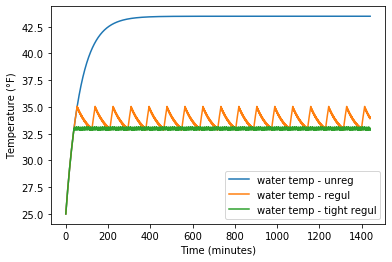

kWh Consumed (unregulated): 12.0
kWh Consumed (regulated): 7.225
kWh Consumed (tightly regulated) 6.775
Improvement: 39.79166666666667 %
Tight Improvement: 43.541666666666664 %
Minimum Ambient Temperature: 10 °F
Time To Recover from 15°F: 100 minutes


In [28]:
# Demonstrate Model in Simple System
t0 = 25
t_amb = 20

model = troughmodel(t0,P,g,k,threshold=45)
mod_1 = troughmodel(t0,P,g,k,threshold=35)
mod_2 = troughmodel(t0,P,g,k,threshold=33)

# Process twenty-four hours
minutes = 60*24
for _ in range(minutes):
    # Update the Model Instances
    model.update(t_amb)
    mod_1.update(t_amb)
    mod_2.update(t_amb)
    # Evaluate the Rest Time
    mod_1_rest = mod_1.rest_time(t_amb)
    mod_2_rest = mod_2.rest_time(t_amb)
    #if (mod_1_rest > 0) and (mod_2_rest > 0):
    #    print("Model 1:",mod_1_rest,"\t\tModel 2:",mod_2_rest)

# Display Results
plt.plot(model.get_temp(),label='water temp - unreg')
plt.plot(mod_1.get_temp(),label='water temp - regul')
plt.plot(mod_2.get_temp(),label='water temp - tight regul')
#plt.plot(model.get_heater_state(),label='heater state')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.show()

rate = sum(model.get_heater_state())/60
rate1 = sum(mod_1.get_heater_state())/60
rate2 = sum(mod_2.get_heater_state())/60
consump = (P/1000) * rate
consump1 = (P/1000) * rate1
consump2 = (P/1000) * rate2
print("kWh Consumed (unregulated):",consump)
print("kWh Consumed (regulated):",consump1)
print("kWh Consumed (tightly regulated)",consump2)
print("Improvement:",(consump-consump1)/consump*100,"%")
print("Tight Improvement:",(consump-consump2)/consump*100,"%")
print("Minimum Ambient Temperature:",model.min_maintain(),"°F")
print("Time To Recover from 15°F:",model.time_to_recover(15),"minutes")

## Start Modeling the Dispatching Sequence

Great! Now we've seen that immense amounts of efficiency can be gained by using a model to more accurately control the water heaters. We've also developed some nice methods of determining the time.

Now we need to develop appropriate methods to dispatch the heaters.

First, we need to find a way of determining how many separate heater groups can be controlled in a period of time. Ultimately, this is determined by the relationship between the amount of time that it takes for a heater to return from freezing to the threshold, and the amount of time required to cool from the threshold to freezing.

If the time required to heat is greater than the time required to cool, there are no effective ways of scheduling heat cycles. When this is true, all heaters must be enabled and controlled by their respective models, heating and cooling as appropriate.

On the contrary, when the time to heat is less than the time to cool, some number of scheduling operations may be completed. This means that some number of heaters can be enabled while others are disabled. As the temperature rises, the number of scheduling periods may also rise. When the number of scheduling periods is zero, all heaters are controlled by their models. When the number of scheduling periods is one, two groups of heaters will be maintained. When the number is two, three groups of heaters will be maintained.

Recovery Time: 12 minutes
Rest Time: 39 minutes
3.0


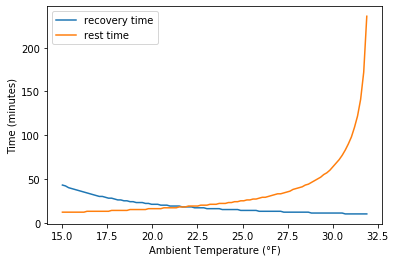

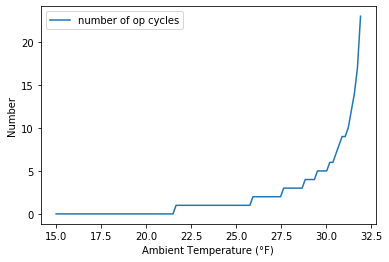

In [40]:
# Model Some Simple Dispatching Considerations
t0 = 32
t_amb = 28
threshold = 35

dispatchmodel = troughmodel(t0,P,g,k,threshold=threshold)

# Evaluate Sample Time to Recover
recoverytime = dispatchmodel.time_to_recover(t_amb,temp_recovr=threshold,t0=t0)
resttime = dispatchmodel.rest_time(t_amb,temp_restart=32,t0=threshold)

print("Recovery Time:",recoverytime,"minutes")
print("Rest Time:",resttime,"minutes")
print(np.floor(resttime/recoverytime))

# Now, let's sweep the ambient temperature to review the performance
ambient = np.linspace(15,31.9,100)

recovery = []
rest = []
n_set = []
for amb in ambient:
    # Evaluate Components
    recoverytime = dispatchmodel.time_to_recover(amb,temp_recovr=threshold,t0=t0)
    resttime = dispatchmodel.rest_time(amb,temp_restart=32,t0=threshold)
    # Store Data Points in Lists
    recovery.append( recoverytime )
    rest.append( resttime )
    # Evaluate the Number of Device Cycles per Rest Cycle
    cyc = np.floor(resttime/recoverytime)
    if cyc >= 0:
        n_set.append(cyc)
    else:
        n_set.append(0)

plt.plot(ambient,recovery,label='recovery time')
plt.plot(ambient,rest,label='rest time')
plt.legend()
plt.xlabel('Ambient Temperature (°F)')
plt.ylabel('Time (minutes)')
plt.show()

plt.plot(ambient,n_set,label='number of op cycles')
plt.xlabel('Ambient Temperature (°F)')
plt.ylabel('Number of Schedule Periods')
plt.legend()
plt.show()